<a href="https://colab.research.google.com/github/alessandrofogli/Reinforcement-Learning-Stocks-Trading/blob/main/RL_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Install and Import dependencies

In [ ]:
!pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 411.5 MB 8.2 kB/s 
     |████████████████████████████████| 412.3 MB 26 kB/s 
     |████████████████████████████████| 240 kB 69.5 MB/s 
     |████████████████████████████████| 171 kB 10.3 MB/s 
     |████████████████████████████████| 50 kB 4.7 MB/s 
     |████████████████████████████████| 3.8 MB 20.5 MB/s 
     |████████████████████████████████| 503 kB 63.2 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=e0104491fbff7eaa8603178209d46f3d31db7b297d82e99b2fb28633960af326
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting

In [ ]:
# Gym stuff
import gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import drive 

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# 1. Bring in Marketwatch GME Data 
https://www.marketwatch.com/investing/stock/gme/download-data?startDate=11/1/2019&endDate=03/12/2021

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Trading/data/btc_data.csv')

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-12-01,19633.769531,19845.974609,18321.921875,18802.998047,18802.998047,49633658712
1,2020-12-02,18801.744141,19308.330078,18347.718750,19201.091797,19201.091797,37387697139
2,2020-12-03,19205.925781,19566.191406,18925.785156,19445.398438,19445.398438,31930317405
3,2020-12-04,19446.966797,19511.404297,18697.193359,18699.765625,18699.765625,33872388058
4,2020-12-05,18698.384766,19160.449219,18590.193359,19154.230469,19154.230469,27242455064


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop(['Adj Close'], axis=1)
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object

In [ ]:
df.sort_values('Date', ascending=True, inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume
0,2020-12-01,19633.769531,19845.974609,18321.921875,18802.998047,49633658712
1,2020-12-02,18801.744141,19308.330078,18347.718750,19201.091797,37387697139
2,2020-12-03,19205.925781,19566.191406,18925.785156,19445.398438,31930317405
3,2020-12-04,19446.966797,19511.404297,18697.193359,18699.765625,33872388058
4,2020-12-05,18698.384766,19160.449219,18590.193359,19154.230469,27242455064


In [ ]:
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-12-01,19633.769531,19845.974609,18321.921875,18802.998047,49633658712
2020-12-02,18801.744141,19308.330078,18347.718750,19201.091797,37387697139
2020-12-03,19205.925781,19566.191406,18925.785156,19445.398438,31930317405
2020-12-04,19446.966797,19511.404297,18697.193359,18699.765625,33872388058
2020-12-05,18698.384766,19160.449219,18590.193359,19154.230469,27242455064


In [ ]:
env = gym.make('stocks-v0', df=df, frame_bound=(5,250), window_size=5)

In [ ]:
env.signal_features

# 2. Build Environment

In [ ]:
env.action_space

Discrete(2)

info {'total_reward': -10883.558599999975, 'total_profit': 0.3390487664662108, 'position': 0}


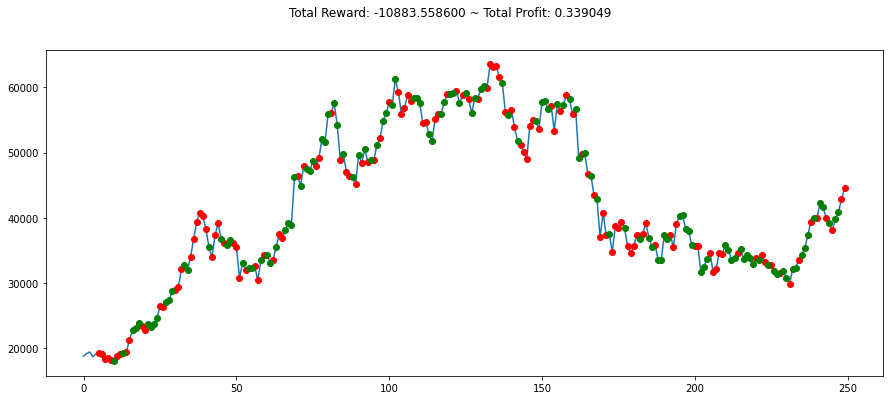

In [ ]:
state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# 2.1 Add Custom Indicators

## 2.1.1. Install and Import New Dependencies

In [ ]:
!pip install finta

In [ ]:
from gym_anytrading.envs import StocksEnv
from finta import TA

## 2.1.2. Fix Volume Column

In [ ]:
#df['Volume'] = df['Volume'].apply(lambda x: float(x.replace(",", "")))
df['Volume'] = df['Volume'].astype(np.float64)

In [ ]:
df.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

In [ ]:
df = df.rename(columns={"Open":"open","High":"high","Low":"low","Close":"close","Volume":"volume", })

In [ ]:
df

,open,high,low,close,volume
Date,,,,,
2020-12-01,19633.769531,19845.974609,18321.921875,18802.998047,4.963366e+10
2020-12-02,18801.744141,19308.330078,18347.718750,19201.091797,3.738770e+10
2020-12-03,19205.925781,19566.191406,18925.785156,19445.398438,3.193032e+10
2020-12-04,19446.966797,19511.404297,18697.193359,18699.765625,3.387239e+10
2020-12-05,18698.384766,19160.449219,18590.193359,19154.230469,2.724246e+10
...,...,...,...,...,...
2022-05-30,29443.365234,31949.630859,29303.572266,31726.390625,3.927799e+10
2022-05-31,31723.865234,32249.863281,31286.154297,31792.310547,3.353821e+10
2022-06-01,31792.554688,31957.285156,29501.587891,29799.080078,4.113582e+10


## 2.1.3. Calculate SMA, RSI and OBV

In [ ]:
ohlc = pd.read_csv('', index_col="Date", parse_dates=True)

TypeError: ignored

In [ ]:
df['SMA'] = TA.SMA(df, 12)
df['RSI'] = TA.RSI(df)
#df['MACD'] = TA.MACD(df,12)
df['BBANDS'] = TA.BBANDS(df,(20,1))
#df['EMA'] = TA.EMA(df)
#df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)
#MACD
#BBANDS
#EMA

ValueError: ignored

In [ ]:
df.head(15)

,Open,High,Low,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2020-12-01,19633.769531,19845.974609,18321.921875,18802.998047,4.963366e+10,0.000000,0.000000,0.000000e+00
2020-12-02,18801.744141,19308.330078,18347.718750,19201.091797,3.738770e+10,0.000000,100.000000,3.738770e+10
2020-12-03,19205.925781,19566.191406,18925.785156,19445.398438,3.193032e+10,0.000000,100.000000,6.931801e+10
2020-12-04,19446.966797,19511.404297,18697.193359,18699.765625,3.387239e+10,0.000000,43.329917,3.544563e+10
2020-12-05,18698.384766,19160.449219,18590.193359,19154.230469,2.724246e+10,0.000000,58.694524,6.268808e+10
2020-12-06,19154.179688,19390.500000,18897.894531,19345.121094,2.529378e+10,0.000000,63.206878,8.798186e+10
2020-12-07,19343.128906,19411.828125,18931.142578,19191.630859,2.689636e+10,0.000000,57.744439,6.108550e+10
2020-12-08,19191.529297,19283.478516,18269.945313,18321.144531,3.169229e+10,0.000000,37.795247,2.939321e+10
2020-12-09,18320.884766,18626.292969,17935.546875,18553.916016,3.442037e+10,0.000000,43.423855,6.381358e+10


## 2.1.4. Create New Environments

In [ ]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [ ]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
    
env2 = MyCustomEnv(df=df, window_size=12, frame_bound=(12,50))

In [ ]:
env2.signal_features

In [ ]:
df.head()

,Open,High,Low,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2020-12-01,19633.769531,19845.974609,18321.921875,18802.998047,4.963366e+10,0.0,0.000000,0.000000e+00
2020-12-02,18801.744141,19308.330078,18347.718750,19201.091797,3.738770e+10,0.0,100.000000,3.738770e+10
2020-12-03,19205.925781,19566.191406,18925.785156,19445.398438,3.193032e+10,0.0,100.000000,6.931801e+10
2020-12-04,19446.966797,19511.404297,18697.193359,18699.765625,3.387239e+10,0.0,43.329917,3.544563e+10
2020-12-05,18698.384766,19160.449219,18590.193359,19154.230469,2.724246e+10,0.0,58.694524,6.268808e+10


# 3. Build Environment and Train

In [ ]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [ ]:
model = A2C('MlpLstmPolicy', env, verbose=1) 
model.learn(total_timesteps=1000000)

Output streaming troncato alle ultime 5000 righe.
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 383       |
| nupdates           | 137600    |
| policy_entropy     | 0.691     |
| total_timesteps    | 688000    |
| value_loss         | 1.28e+04  |
----------------------------------
---------------------------------
| explained_variance | -0.188   |
| fps                | 383      |
| nupdates           | 137700   |
| policy_entropy     | 0.615    |
| total_timesteps    | 688500   |
| value_loss         | 2.59e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 383      |
| nupdates           | 137800   |
| policy_entropy     | 0.692    |
| total_timesteps    | 689000   |
| value_loss         | 1.05e+04 |
---------------------------------
---------------------------------
| explained_variance | -140     |
| fps                | 383      |
| nupdates           | 1

# 4. Evaluation

In [ ]:
env = MyCustomEnv(df=df, window_size=12, frame_bound=(100,140))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': -5409.273437999989, 'total_profit': 0.805566602907617, 'position': 1}


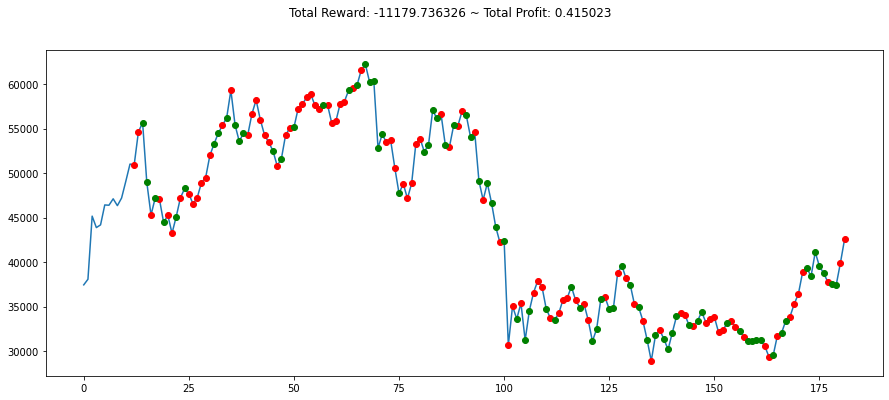

In [ ]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()